# Modelado de Regresión

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict

## Lectura de dataframes

In [2]:
df = pd.read_csv('../data/dataframe_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_edit = pd.read_csv('../data_edit/dataframe_edit_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_2017 = pd.read_csv('../data/dataframe_2017_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_edit_2017 = pd.read_csv('../data_edit/dataframe_2017_edit_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)

## Distribución de la dosis de coagulante en cada uno de los dataframes

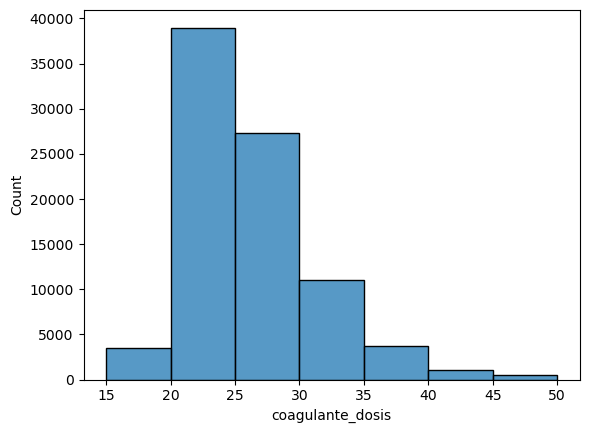

In [3]:
sns.histplot(df.coagulante_dosis, kde=False, bins=7)
plt.show()

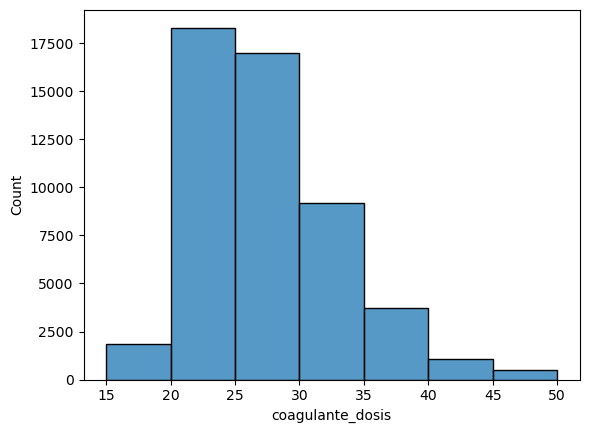

In [4]:
sns.histplot(df_edit.coagulante_dosis, kde=False, bins=7)
plt.show()

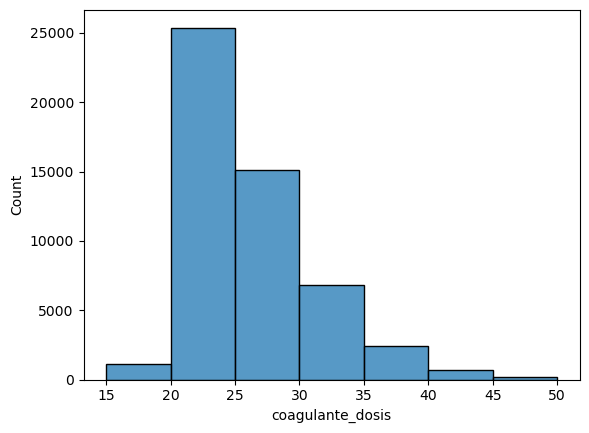

In [5]:
sns.histplot(df_2017.coagulante_dosis, kde=False, bins=7)
plt.show()

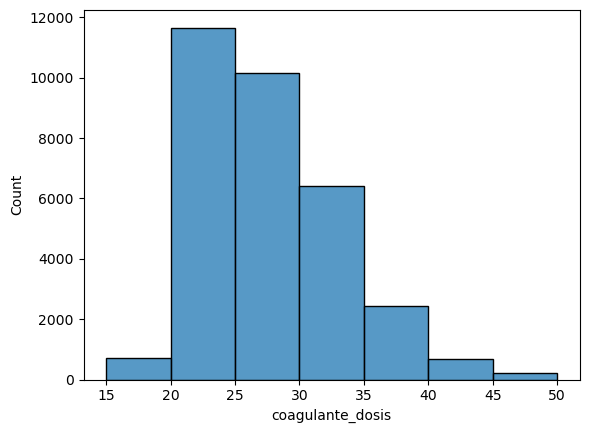

In [6]:
sns.histplot(df_edit_2017.coagulante_dosis, kde=False, bins=7)
plt.show()

In [7]:
# def boxcox_transform(df):
#     for col in df.columns:
#         # Comprueba que todos los valores en la columna sean mayores que cero
#         if df[col].min() > 0:
#             df[col], maxlog = stats.boxcox(df[col])
#             print(f"Transformación Box-Cox realizada en {col}. Lambda optimizado es: {maxlog}")
#         else:
#             print(f"No se realizó la transformación Box-Cox en {col} debido a la presencia de cero o valores negativos.")
#     return df

In [8]:
# Aplica la función al DataFrame
# df_transform = boxcox_transform(df)

In [9]:
# sns.histplot(df_transform.caudal, kde=False, bins=7)
# plt.show()

## Eliminación de columnas que pueden producir multicolinealidad

En el cuaderno 13 se definió el por qué se eliminaban dichas columnas para este análisis se eliminarán las mismas columnas para evitar la multicolinealidad en el modelado

In [10]:
df = df.drop(['agua_cruda_color', 'clasificador_horario'], axis=1)
df_edit = df_edit.drop(['agua_cruda_color', 'clasificador_horario'], axis=1)
df_2017 = df_2017.drop(['agua_cruda_ntu', 'clasificador_horario'], axis=1)
df_edit_2017 = df_edit_2017.drop(['agua_cruda_ntu', 'clasificador_horario'], axis=1)

## Transformación de columna de dosis de coagulante

In [11]:
df['coagulante_dosis'] = df['coagulante_dosis'].round().astype(int)
df_edit['coagulante_dosis'] = df_edit['coagulante_dosis'].round().astype(int)
df_2017['coagulante_dosis'] = df_2017['coagulante_dosis'].round().astype(int)
df_edit_2017['coagulante_dosis'] = df_edit_2017['coagulante_dosis'].round().astype(int)

In [12]:
def boxcox_transform(df, column):
    if column in df.columns and (df[column] > 0).all():
        df[column], maxlog = stats.boxcox(df[column])
        print(f"Transformación Box-Cox realizada en '{column}'. Lambda optimizado es: {maxlog}")
    else:
        print(f"La columna '{column}' no se encontró en el dataframe o contiene valores no positivos.")
    return df, maxlog

In [13]:
df_transformed, maxlog_df = boxcox_transform(df, 'coagulante_dosis')
df_edit_transformed, maxlog_df_edit = boxcox_transform(df_edit, 'coagulante_dosis')
df_2017_transformed, maxlog_df_2017 = boxcox_transform(df_2017, 'coagulante_dosis')
df_edit_2017_transformed, maxlog_df_edit_2017 = boxcox_transform(df_edit_2017, 'coagulante_dosis')

Transformación Box-Cox realizada en 'coagulante_dosis'. Lambda optimizado es: -0.6363501582427542
Transformación Box-Cox realizada en 'coagulante_dosis'. Lambda optimizado es: -0.44943810721097327
Transformación Box-Cox realizada en 'coagulante_dosis'. Lambda optimizado es: -0.9570715128232756
Transformación Box-Cox realizada en 'coagulante_dosis'. Lambda optimizado es: -0.5995455577950439


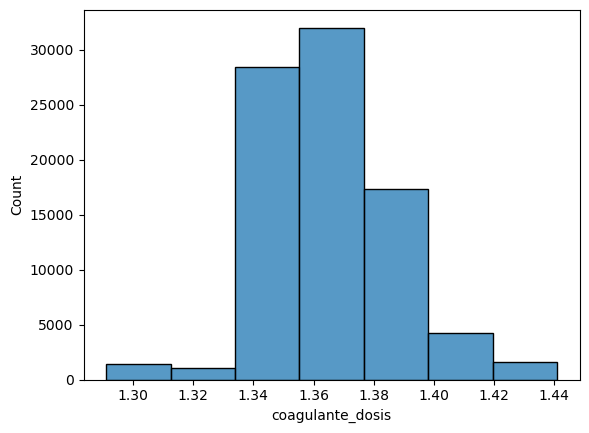

In [14]:
sns.histplot(df_transformed.coagulante_dosis, kde=False, bins=7)
plt.show()

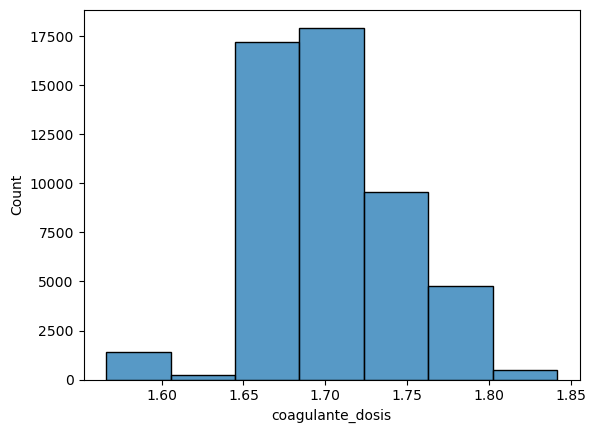

In [15]:
sns.histplot(df_edit_transformed.coagulante_dosis, kde=False, bins=7)
plt.show()

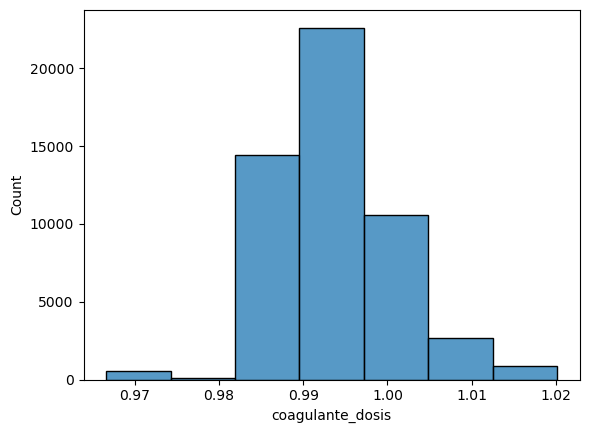

In [16]:
sns.histplot(df_2017_transformed.coagulante_dosis, kde=False, bins=7)
plt.show()

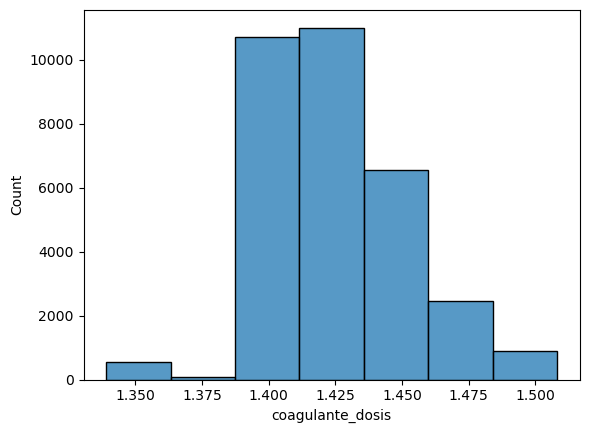

In [17]:
sns.histplot(df_edit_2017_transformed.coagulante_dosis, kde=False, bins=7)
plt.show()

In [18]:
df_transformed

,caudal,agua_cruda_p_h,agua_cruda_ntu,agua_cruda_alcalinidad,agua_cruda_conductividad,coagulante_dosis,vel_viento,precipitacion,temp_humeda,clasificador_mensual
0,545.0,7.5,2.1,38.170,81.582,1.373817,1.531917,0.000,15.356,1.0
1,516.0,7.8,2.4,34.996,62.998,1.351649,1.541917,0.002,14.344,1.0
2,557.0,7.8,2.4,35.061,67.350,1.337905,1.236833,0.000,14.444,1.0
3,541.0,7.8,2.3,39.148,79.722,1.337905,1.058250,0.000,13.000,1.0
4,540.0,7.8,2.3,33.008,69.692,1.357780,1.030867,0.020,17.864,1.0
...,...,...,...,...,...,...,...,...,...,...
86045,600.0,7.4,657.0,25.000,55.500,1.421206,1.308333,0.000,17.498,1.0
86046,620.0,7.5,404.0,25.000,55.700,1.421206,0.800000,0.000,15.684,1.0
86047,620.0,7.3,402.0,25.000,55.400,1.421206,0.541667,0.000,16.075,1.0
86048,510.0,7.4,390.0,25.000,55.500,1.421206,0.475000,0.000,15.999,1.0


In [19]:
# df_transformed['coagulante_dosis'] = inv_boxcox(df['coagulante_dosis'], maxlog_df)

## Regresión lineal

In [20]:
# def run_lineal_regression(df, df_transformed, target_col='coagulante_dosis'):
#     y = df[target_col]
#     X = df.drop(target_col, axis=1)
#     y_transformed = df_transformed[target_col]
#     X_transformed = df_transformed.drop(target_col, axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
#     X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, train_size=0.7)
    
#     # Crear una cadena con los nombres de las columnas de X para usar en la fórmula
#     predictors = ' + '.join(X.columns)
#     formula = f'{target_col} ~ {predictors}'
#     predictors_transformed = ' + '.join(X_transformed.columns)
#     formula_transformed = f'{target_col} ~ {predictors_transformed}'
    
#     # Ajustar modelo OLS
#     print(
#         smf.ols(
#             formula=formula,
#             data=df
#         )
#         .fit()
#         .summary()
#     )
    
#     # Ajustar modelo OLS
#     print(
#         smf.ols(
#             formula=formula_transformed,
#             data=df_transformed
#         )
#         .fit()
#         .summary()
#     )
    
# #     # Crear un modelo de regresión lineal
# #     model = LinearRegression()
# #     model_transformed = LinearRegression()

# #     # Ajustar el modelo a los datos de entrenamiento
# #     model.fit(X_train, y_train)
# #     model_transformed.fit(X_train_transformed, y_train_transformed)
    
# #     # Hacer predicciones en los datos de prueba
# #     y_pred = model.predict(X_test)
# #     y_pred_transformed = model_transformed.predict(X_test_transformed)
    
# #     # Calcular el error cuadrático medio (MSE)
# #     mse = metrics.mean_squared_error(y_test, y_pred)
# #     mse_transformed = metrics.mean_squared_error(y_test_transformed, y_pred_transformed)

# #     # Calcular la raíz del error cuadrático medio (RMSE)
# #     rmse = np.sqrt(mse)
# #     rmse_transformed = np.sqrt(mse_transformed)

# #     # Calcular el error absoluto medio (MAE)
# #     mae = metrics.mean_absolute_error(y_test, y_pred)
# #     mae_transformed = metrics.mean_absolute_error(y_test_transformed, y_pred_transformed)

# #     # Calcular el coeficiente de determinación R^2
# #     r2 = metrics.r2_score(y_test, y_pred)
# #     r2_transformed = metrics.r2_score(y_test_transformed, y_pred_transformed)

# #     print('Mean Squared Error (MSE):', mse)
# #     print('Mean Squared Error (MSE) with transformed:', mse_transformed)
# #     print('Root Mean Squared Error (RMSE):', rmse)
# #     print('Root Mean Squared Error (RMSE) with transformed:', rmse_transformed)
# #     print('Mean Absolute Error (MAE):', mae)
# #     print('Mean Absolute Error (MAE) with transformed:', mae_transformed)
# #     print('R^2:', r2)
# #     print('R^2 with transformed:', r2_transformed)

In [21]:
def run_lineal_regression(df, df_transformed, target_col='coagulante_dosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    y_transformed = df_transformed[target_col]
    X_transformed = df_transformed.drop(target_col, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, train_size=0.7)
    
    # Crear una cadena con los nombres de las columnas de X para usar en la fórmula
    predictors = ' + '.join(X.columns)
    formula = f'{target_col} ~ {predictors}'
    predictors_transformed = ' + '.join(X_transformed.columns)
    formula_transformed = f'{target_col} ~ {predictors_transformed}'
    
    # Ajustar modelo OLS
    model = smf.ols(formula=formula, data=df).fit()
#     print(model.summary())
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)

    
    print(f"MAE: {mae:.5f}")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5F}")
    print(f"R^2: {r2:.5F}")
    
    # Ajustar modelo OLS con datos transformados
    model_transformed = smf.ols(formula=formula_transformed, data=df_transformed).fit()
#     print(model_transformed.summary())
    
    # Realizar predicciones con datos transformados
    y_pred_transformed = model_transformed.predict(X_test_transformed)
    
    # Calcular métricas para datos transformados
    mae_transformed = mean_absolute_error(y_test_transformed, y_pred_transformed)
    mse_transformed = mean_squared_error(y_test_transformed, y_pred_transformed)
    rmse_transformed = np.sqrt(mse_transformed)
    r2_transformed = r2_score(y_test_transformed, y_pred_transformed)
    
    print(f"Transformed MAE: {mae_transformed:.5f}")
    print(f"Transformed MSE: {mse_transformed:.5f}")
    print(f"Transformed RMSE: {rmse_transformed:.5f}")
    print(f"R^2: {r2_transformed:.5F}")

In [22]:
# run_lineal_regression(df, df_transformed)

In [23]:
# run_lineal_regression(df_edit, df_edit_transformed)

In [24]:
# run_lineal_regression(df_2017, df_2017_transformed)

In [25]:
# run_lineal_regression(df_edit_2017, df_edit_2017_transformed)

Basándonos en los resultados proporcionados, hay varios puntos interesantes que podemos analizar:

El coeficiente R-cuadrado para todos los modelos es no es un valor muy alto, lo que podría sugerir que hay otras variables no incluidas en el modelo que podrían ayudar a explicar la dosis de coagulante o que las variables usadas no tienen una relación lineal con la dosis de coagulante.

Vamos a enfatizar por grupos. Los dataframes que cuentan con datos de todos los años: 
1. En el primer caso: 
- La variable dependiente es "coagulante_dosis". El R-cuadrado es 0.176, lo que indica que el modelo explica aproximadamente el 17.6% de la variabilidad de la dosis del coagulante.
- El F-statistic es 2036 y el Prob (F-statistic) es 0.00, lo que indica que el modelo es significativo.
- Las variables que resultan ser significativas (p-valor < 0.05) son: agua_cruda_p_h, agua_cruda_ntu, agua_cruda_alcalinidad, agua_cruda_conductividad, vel_viento, precipitacion, temp_humeda, y clasificador_mensual. Por otro lado, la variable caudal no es significativa en este modelo (p-valor > 0.05).
Nota: un coeficiente positivo indica que a medida que la variable independiente aumenta, también lo hace la variable dependiente (manteniendo todas las demás constantes). Un coeficiente negativo indica que a medida que la variable independiente aumenta, la variable dependiente disminuye (manteniendo todas las demás constantes).

2. En el segundo caso:

- La variable dependiente sigue siendo "coagulante_dosis". El R-cuadrado es 0.170, lo que indica que el modelo explica aproximadamente el 17% de la variabilidad de la dosis del coagulante.
- El F-statistic es 1170 y el Prob (F-statistic) es 0.00, lo que indica que el modelo es significativo.
- Todas las variables en este modelo son significativas (p-valor < 0.05).
En términos generales, el primer modelo parece ser ligeramente mejor en términos de R-cuadrado, pero ambos modelos no son particularmente fuertes ya que solo explican alrededor del 17% de la variabilidad en la dosis de coagulante.

Para los dataframes que cuenan con datos a partir del año 2017: 

3. Tercer caso:

- El R-cuadrado y el R-cuadrado ajustado para este modelo son ambos 0.236, lo que significa que este modelo explica el 23.6% de la variabilidad en la dosis de coagulante. Es un valor moderado y podría indicar que hay otras variables no consideradas en el modelo que también podrían estar influyendo en la dosis de coagulante.
- El valor de F-statistic es 1776 y la Prob (F-statistic) es 0. Esto indica que al menos una de las variables independientes es significativa para predecir la variable dependiente.
- Los coeficientes muestran cómo cada variable independiente afecta a la variable dependiente. Por ejemplo, un incremento en una unidad de "agua_cruda_p_h" disminuirá la dosis de coagulante en 0.0024 unidades.
- El valor p asociado con cada coeficiente indica su significancia. Un valor p inferior a 0.05 sugiere que la variable es significativa para el modelo. En este caso, todas las variables excepto "clasificador_mensual" son significativas.
- La métrica Durbin-Watson de 0.224 sugiere que hay una autocorrelación positiva de los residuos, lo que puede indicar que el modelo no está captando toda la información disponible en los datos.

4. Cuarto caso:

- Similarmente al anterior modelo, este modelo explica el 22.5% de la variabilidad en la dosis de coagulante.
- El valor de F-statistic es 1043 y la Prob (F-statistic) es 0, también sugiriendo que al menos una de las variables independientes es significativa.
- Todos los coeficientes en este modelo son significativos ya que todos los valores p son inferiores a 0.05.
- El Durbin-Watson es de 0.166, sugiriendo también la posible autocorrelación positiva de los residuos.

En general el modelo sin transformada ofreció mejores resultados, por lo tanto para los próximos análisis se procederá a evaluar los dataframes sin transformada.

## Modelado con otros algoritmos

In [26]:
def run_regression_algorithms(dataframes, target_col='coagulante_dosis'):
    base_estimators = [RandomForestRegressor(), ExtraTreesRegressor(), KNeighborsRegressor(), 
                       LinearRegression(), DecisionTreeRegressor(), GradientBoostingRegressor()]
    base_estimators_names = ['Random Forest', 'Extra Trees', 'K-Nearest Neighbors', 'Linear Regression',
                             'Decision Tree', 'Gradient Boosting']

    for i, df in enumerate(dataframes):
        print(f"\nTrabajando con el dataframe número {i+1}")
        
        # Preparar datos
        y = df[target_col]
        X = df.drop(target_col, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

        # Ejecutar modelos
        for estimator, name in zip(base_estimators, base_estimators_names):
            print(f"\nEjecutando algoritmo {name}")
            a_est = estimator
            a_est.fit(X_train, y_train)
            pred_y = a_est.predict(X_test)
            mostrar_resultados(y_test, pred_y)

def mostrar_resultados(y_test, pred_y):
    mse = mean_squared_error(y_test, pred_y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred_y)
    r2 = r2_score(y_test, pred_y)

    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
#     print("R2: ", r2)

In [27]:
dataframes = [df, df_edit, df_2017, df_edit_2017]
run_regression_algorithms(dataframes)


Trabajando con el dataframe número 1

Ejecutando algoritmo Random Forest
MSE:  0.0001777339497433807
RMSE:  0.013331689680733673
MAE:  0.008269554766036486

Ejecutando algoritmo Extra Trees
MSE:  0.00015533093286056112
RMSE:  0.01246318309504282
MAE:  0.007665700315821162

Ejecutando algoritmo K-Nearest Neighbors
MSE:  0.00032710900526577264
RMSE:  0.01808615507137359
MAE:  0.01249082707367407

Ejecutando algoritmo Linear Regression
MSE:  0.0004790167966263432
RMSE:  0.021886452353598634
MAE:  0.017344649131167966

Ejecutando algoritmo Decision Tree
MSE:  0.00037126432858774973
RMSE:  0.01926822069075787
MAE:  0.010305759292008792

Ejecutando algoritmo Gradient Boosting
MSE:  0.00029148721677193135
RMSE:  0.01707299671328766
MAE:  0.012071832568588783

Trabajando con el dataframe número 2

Ejecutando algoritmo Random Forest
MSE:  0.0009699538013723909
RMSE:  0.031144081321695636
MAE:  0.022106744584489933

Ejecutando algoritmo Extra Trees
MSE:  0.0008202741481544963
RMSE:  0.028640428

Las métricas que se están usando para evaluar los modelos son el error cuadrático medio (MSE), la raiz cuadrada del error cuadrático medio (RMSE), el error absoluto medio (MAE) y el coeficiente de determinación (R2). El MSE, el RMSE y el MAE son medidas de error, donde valores más bajos son mejores. El coeficiente de determinación, o R2, es una medida de qué tan bien el modelo se ajusta a los datos, con 1 siendo un ajuste perfecto.

Los resultados de los algoritmos de machine learning aplicados a los distintos conjuntos de datos son los siguientes:

1. DataFrame 1: El algoritmo que obtuvo el mejor rendimiento fue Extra Trees con un R2 de 0.7143 y los errores MSE, RMSE y MAE más bajos.

2. DataFrame 2: Extra Trees también resultó ser el mejor algoritmo en este conjunto de datos, con un R2 de 0.6642 y los errores MSE, RMSE y MAE más bajos.

3. DataFrame 3: En este caso, Extra Trees sigue siendo el algoritmo superior, obteniendo un R2 de 0.7604 y los errores más bajos.

4. DataFrame 4: Extra Trees una vez más obtuvo el mejor rendimiento, con un R2 de 0.7195 y los errores más bajos.

En conclusión, basándose en la métrica R2 y los errores, el algoritmo Extra Trees ha demostrado ser el más eficaz para estos conjuntos de datos específicos.

En cuanto a los dataframes, el dataframe 3 resultó tener los errores más bajos y el R2 más alto en comparación con los demás, lo que sugiere que los algoritmos pueden predecir con mayor precisión los datos de este dataframe. Esto puede deberse a varias razones, incluyendo una mejor preparación de los datos, una mayor cantidad de características informativas, o simplemente una naturaleza menos ruidosa o aleatoria de los datos.

Por otro lado, el dataframe 2 tuvo el rendimiento más bajo, lo que indica que los algoritmos tuvieron dificultades para predecir con precisión los datos de este conjunto.

In [28]:
def train_and_evaluate_rf(df, n_estimators, max_depth, min_samples_split, target='coagulante_dosis'):
    # Definir X e y
    y = df[target]
    X = df.drop(target, axis=1)

    # Divide tus datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crea un nuevo clasificador con los mejores hiperparámetros
    clf = make_pipeline(RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42))

    # Entrena el clasificador en el conjunto de entrenamiento
    clf.fit(X_train, y_train)

    # Prueba el clasificador en el conjunto de prueba
    pred_y = clf.predict(X_test)

    # Predicciones en el conjunto de entrenamiento
    train_preds = clf.predict(X_train)
    
    mostrar_resultados(y_train, train_preds, y_test, pred_y)
        
def mostrar_resultados(y_train, train_preds, y_test, pred_y):
    mse_train = mean_squared_error(y_train, train_preds)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_preds)
    r2_train = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_test, pred_y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred_y)
    r2 = r2_score(y_test, pred_y)
    # Calcular la media de la variable objetivo
    mean_target = np.mean(y_test)

    # Calcular el porcentaje en el que RMSE, MSE y MAE exceden la media
    rmse_percentage = (rmse / mean_target) * 100
    mse_percentage = (mse / mean_target) * 100
    mae_percentage = (mae / mean_target) * 100

    print('El RMSE excede el {}% de la media de la variable objetivo.'.format(rmse_percentage))
    print('El MSE excede el {}% de la media de la variable objetivo.'.format(mse_percentage))
    print('El MAE excede el {}% de la media de la variable objetivo.'.format(mae_percentage))
    print("Informe de clasificación para el conjunto de entrenamiento:")
    print("MSE: ", mse_train)
    print("RMSE: ", rmse_train)
    print("MAE: ", mae_train)
    print("R2: ", r2_train)
    print("Informe de clasificación para el conjunto de prueba:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R2: ", r2)

In [29]:
def train_and_evaluate_et(df, n_estimators, max_depth, min_samples_split, target='coagulante_dosis'):
    # Definir X e y
    y = df[target]
    X = df.drop(target, axis=1)

    # Divide tus datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crea un nuevo clasificador con los mejores hiperparámetros
    clf = make_pipeline(ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42))

    # Entrena el clasificador en el conjunto de entrenamiento
    clf.fit(X_train, y_train)

    # Prueba el clasificador en el conjunto de prueba
    pred_y = clf.predict(X_test)

    # Predicciones en el conjunto de entrenamiento
    train_preds = clf.predict(X_train)

    mostrar_resultados(y_train, train_preds, y_test, pred_y)

    
def mostrar_resultados(y_train, train_preds, y_test, pred_y):
    mse_train = mean_squared_error(y_train, train_preds)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_preds)
    r2_train = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_test, pred_y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred_y)
    r2 = r2_score(y_test, pred_y)
    # Calcular la media de la variable objetivo
    mean_target = np.mean(y_test)

    # Calcular el porcentaje en el que RMSE, MSE y MAE exceden la media
    rmse_percentage = (rmse / mean_target) * 100
    mse_percentage = (mse / mean_target) * 100
    mae_percentage = (mae / mean_target) * 100

    print('El RMSE excede el {}% de la media de la variable objetivo.'.format(rmse_percentage))
    print('El MSE excede el {}% de la media de la variable objetivo.'.format(mse_percentage))
    print('El MAE excede el {}% de la media de la variable objetivo.'.format(mae_percentage))
    print("Informe de clasificación para el conjunto de entrenamiento:")
    print("MSE: ", mse_train)
    print("RMSE: ", rmse_train)
    print("MAE: ", mae_train)
    print("R2: ", r2_train)
    print("Informe de clasificación para el conjunto de prueba:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R2: ", r2)

In [30]:
def evaluate_model_cv_rf(df, n_estimators, max_depth, min_samples_split, target_col='coagulante_dosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    
    # Crear un pipeline para estandarizar los datos y luego aplicar el regresor
    reg = make_pipeline(RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42))

    # Realiza la validación cruzada y obtén las predicciones
    test_preds = cross_val_predict(reg, X, y, cv=5)

    # Calcular las métricas
    mse_test = mean_squared_error(y, test_preds)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y, test_preds)
    r2_test = r2_score(y, test_preds)
    
    # Calcular la media de la variable objetivo
    mean_target = np.mean(y)

    # Calcular el porcentaje en el que RMSE, MSE y MAE exceden la media
    rmse_percentage = (rmse_test / mean_target) * 100
    mse_percentage = (mse_test / mean_target) * 100
    mae_percentage = (mae_test / mean_target) * 100

    print('El RMSE excede el {}% de la media de la variable objetivo.'.format(rmse_percentage))
    print('El MSE excede el {}% de la media de la variable objetivo.'.format(mse_percentage))
    print('El MAE excede el {}% de la media de la variable objetivo.'.format(mae_percentage))
    print("Informe de clasificación:")
    print("MSE: ", mse_test)
    print("RMSE: ", rmse_test)
    print("MAE: ", mae_test)
    print("R2: ", r2_test)

In [31]:
def evaluate_model_cv_et(df, n_estimators, max_depth, min_samples_split, target_col='coagulante_dosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    
    # Crear un pipeline para estandarizar los datos y luego aplicar el regresor
    reg = make_pipeline(ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42))

    # Realiza la validación cruzada y obtén las predicciones
    test_preds = cross_val_predict(reg, X, y, cv=5)

    # Calcular las métricas
    mse_test = mean_squared_error(y, test_preds)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y, test_preds)
    r2_test = r2_score(y, test_preds)
    
    # Calcular la media de la variable objetivo
    mean_target = np.mean(y)

    # Calcular el porcentaje en el que RMSE, MSE y MAE exceden la media
    rmse_percentage = (rmse_test / mean_target) * 100
    mse_percentage = (mse_test / mean_target) * 100
    mae_percentage = (mae_test / mean_target) * 100

    print('El RMSE excede el {}% de la media de la variable objetivo.'.format(rmse_percentage))
    print('El MSE excede el {}% de la media de la variable objetivo.'.format(mse_percentage))
    print('El MAE excede el {}% de la media de la variable objetivo.'.format(mae_percentage))
    print("Informe de clasificación:")
    print("MSE: ", mse_test)
    print("RMSE: ", rmse_test)
    print("MAE: ", mae_test)
    print("R2: ", r2_test)

## Dataframe completo

### Random Forest

In [32]:
# Uso de la función
train_and_evaluate_rf(df, 150, 20, 15)

El RMSE excede el 1.0109917187338247% de la media de la variable objetivo.
El MSE excede el 0.013944182304623362% de la media de la variable objetivo.
El MAE excede el 0.6485353008579526% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  9.130903850686221e-05
RMSE:  0.009555576304277112
MAE:  0.006176602082675117
R2:  0.8432067476484264
Informe de clasificación para el conjunto de prueba:
MSE:  0.00019023521243270679
RMSE:  0.013792578164821354
MAE:  0.008847722156351599
R2:  0.6683017649107992


In [33]:
evaluate_model_cv_rf(df, 150, 20, 15)

El RMSE excede el 1.2881893089126795% de la media de la variable objetivo.
El MSE excede el 0.022637640824701263% de la media de la variable objetivo.
El MAE excede el 0.8334874427916736% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.0003088182439011685
RMSE:  0.017573225199182092
MAE:  0.011370271769474326
R2:  0.4680939487381328


### Extra Trees

In [34]:
# Uso de la función
train_and_evaluate_et(df, 150, 25, 10)

El RMSE excede el 0.9679406114307201% de la media de la variable objetivo.
El MSE excede el 0.01278189598620187% de la media de la variable objetivo.
El MAE excede el 0.6287494491452954% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  6.831134690674922e-05
RMSE:  0.008265067870668046
MAE:  0.005377091348116377
R2:  0.8826977216147023
Informe de clasificación para el conjunto de prueba:
MSE:  0.0001743785791886599
RMSE:  0.013205248168385928
MAE:  0.008577791254596866
R2:  0.6959497339394964


In [35]:
evaluate_model_cv_et(df, 150, 25, 10)

El RMSE excede el 1.276557146907508% de la media de la variable objetivo.
El MSE excede el 0.02223065745387514% de la media de la variable objetivo.
El MAE excede el 0.8374993943479521% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.00030326625679929874
RMSE:  0.01741454153284831
MAE:  0.011425002023559575
R2:  0.4776566465201896


## Dataframe completo con edición

### Random Forest

In [36]:
# Uso de la función
train_and_evaluate_rf(df_edit, 150, 20, 15)

El RMSE excede el 1.8910094666893904% de la media de la variable objetivo.
El MSE excede el 0.06068043644432972% de la media de la variable objetivo.
El MAE excede el 1.379027097737144% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  0.0005071902341209491
RMSE:  0.022520884399173782
MAE:  0.01651096165558084
R2:  0.7918307364231333
Informe de clasificación para el conjunto de prueba:
MSE:  0.0010296982759423032
RMSE:  0.032088912040489984
MAE:  0.023400982396037877
R2:  0.5651651388713179


In [37]:
evaluate_model_cv_rf(df_edit, 150, 20, 15)

El RMSE excede el 2.499829044110961% de la media de la variable objetivo.
El MSE excede el 0.10604626172460734% de la media de la variable objetivo.
El MAE excede el 1.8791199544625474% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.001799575650151278
RMSE:  0.04242140556548401
MAE:  0.03188814446421449
R2:  0.2572177592844801


### Extra Trees

In [38]:
# Uso de la función
train_and_evaluate_et(df_edit, 150, 25, 10)

El RMSE excede el 1.8077615967775833% de la media de la variable objetivo.
El MSE excede el 0.05545536935571234% de la media de la variable objetivo.
El MAE excede el 1.3143555771052178% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  0.00037152064825241786
RMSE:  0.019274870901057103
MAE:  0.01409877770056211
R2:  0.8475144540502667
Informe de clasificación para el conjunto de prueba:
MSE:  0.0009410330835327494
RMSE:  0.030676262541788714
MAE:  0.02230355862654414
R2:  0.6026078709115108


In [39]:
evaluate_model_cv_et(df_edit, 150, 25, 10)

El RMSE excede el 2.5057755005125486% de la media de la variable objetivo.
El MSE excede el 0.10655137585721196% de la media de la variable objetivo.
El MAE excede el 1.896269887005678% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.001808147296891105
RMSE:  0.04252231528140377
MAE:  0.03217917406303715
R2:  0.25367977688763266


## Dataframe 2017-2022 sin edición

### Random Forest

In [40]:
# Uso de la función
train_and_evaluate_rf(df_2017, 150, 20, 15)

El RMSE excede el 0.447599634095188% de la media de la variable objetivo.
El MSE excede el 0.001993626182448763% de la media de la variable objetivo.
El MAE excede el 0.28915535975155154% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  9.168238497129758e-06
RMSE:  0.003027909922228493
MAE:  0.0019718880943074904
R2:  0.8635274089133553
Informe de clasificación para el conjunto de prueba:
MSE:  1.9838462533918557e-05
RMSE:  0.0044540389012578865
MAE:  0.0028773687973273417
R2:  0.7037466996415301


In [41]:
evaluate_model_cv_rf(df_2017, 150, 20, 15)

El RMSE excede el 0.6232620265653891% de la media de la variable objetivo.
El MSE excede el 0.00386507455394676% de la media de la variable objetivo.
El MAE excede el 0.4273811280855707% de la media de la variable objetivo.
Informe de clasificación:
MSE:  3.8456912671296495e-05
RMSE:  0.0062013637751140264
MAE:  0.004252378185917231
R2:  0.427212696591613


### Extra Trees

In [42]:
# Uso de la función
train_and_evaluate_et(df_2017, 150, 25, 10)

El RMSE excede el 0.4310382377293102% de la media de la variable objetivo.
El MSE excede el 0.0018488253185316727% de la media de la variable objetivo.
El MAE excede el 0.2853538641186644% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  6.289344098824802e-06
RMSE:  0.00250785647492531
MAE:  0.001667724801272105
R2:  0.9063808074287303
Informe de clasificación para el conjunto de prueba:
MSE:  1.8397557243354105e-05
RMSE:  0.00428923737316485
MAE:  0.0028395403271006653
R2:  0.7252641406782969


In [43]:
evaluate_model_cv_et(df_2017, 150, 25, 10)

El RMSE excede el 0.6282616089415484% de la media de la variable objetivo.
El MSE excede el 0.003927331716725989% de la media de la variable objetivo.
El MAE excede el 0.4409225027045158% de la media de la variable objetivo.
Informe de clasificación:
MSE:  3.907636211237356e-05
RMSE:  0.00625110887062236
MAE:  0.00438711283434421
R2:  0.4179864547977109


## Dataframe 2017-2022 con edición

### Random Forest

In [44]:
# Uso de la función
train_and_evaluate_rf(df_edit_2017, 150, 20, 15)

El RMSE excede el 1.2137033064390517% de la media de la variable objetivo.
El MSE excede el 0.020959284418326576% de la media de la variable objetivo.
El MAE excede el 0.8943880150466808% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  0.0001417935352575017
RMSE:  0.011907709068393538
MAE:  0.008707595110530342
R2:  0.8390719050545239
Informe de clasificación para el conjunto de prueba:
MSE:  0.0002982138654100862
RMSE:  0.01726886983592401
MAE:  0.012725573155079129
R2:  0.6607879423587185


In [45]:
evaluate_model_cv_rf(df_edit_2017, 150, 20, 15)

El RMSE excede el 1.730181193483275% de la media de la variable objetivo.
El MSE excede el 0.042601255619331625% de la media de la variable objetivo.
El MAE excede el 1.3448850620091837% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.0006062637828922065
RMSE:  0.024622424391034414
MAE:  0.019139227081347222
R2:  0.3116326122767674


### Extra Trees

In [46]:
# Uso de la función
train_and_evaluate_et(df_edit_2017, 150, 25, 10)

El RMSE excede el 1.1486428537441968% de la media de la variable objetivo.
El MSE excede el 0.018772469651387822% de la media de la variable objetivo.
El MAE excede el 0.8408474876690901% de la media de la variable objetivo.
Informe de clasificación para el conjunto de entrenamiento:
MSE:  9.117915296789397e-05
RMSE:  0.009548777564059913
MAE:  0.007000193886261803
R2:  0.8965165276455083
Informe de clasificación para el conjunto de prueba:
MSE:  0.0002670993258309372
RMSE:  0.01634317367682719
MAE:  0.011963785333191236
R2:  0.696180082756652


In [47]:
evaluate_model_cv_et(df_edit_2017, 150, 25, 10)

El RMSE excede el 1.7345337972706112% de la media de la variable objetivo.
El MSE excede el 0.04281586854557863% de la media de la variable objetivo.
El MAE excede el 1.3594148900795762% de la media de la variable objetivo.
Informe de clasificación:
MSE:  0.0006093179662169119
RMSE:  0.02468436683848528
MAE:  0.019346002877099405
R2:  0.30816481450262745


Basándonos en los resultados se puede concluir que el mejor modelo parece ser el generado por el algoritmo RF aplicado al conjunto de datos "Sin edición 2017-2022". Con este modelo se hará una pequeña evaluación para ver que tanta proximidad a los valores reales se tiene.

In [58]:
def model(df, n_estimators, max_depth, min_samples_split, target_col='coagulante_dosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    print(y)
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear un pipeline para estandarizar los datos y luego aplicar el clasificador
    clf= make_pipeline(RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42))
    clf.fit(X_train, y_train)
    
    return clf

In [59]:
model = model(df_2017, 150, 20, 15)

0        0.985442
1        0.985442
2        0.985442
3        0.985442
4        0.985442
           ...   
51803    1.014251
51804    1.014251
51805    1.014251
51806    1.014251
51807    1.014251
Name: coagulante_dosis, Length: 51808, dtype: float64


In [60]:
def inverse_box_cox(y, lambda_value):
    if lambda_value != 0:
        return np.exp(np.log(lambda_value * y + 1) / lambda_value)
    else:
        return np.exp(y)

In [61]:
def predict_and_display(model, input_df):
    # Asegurarte de que las columnas del dataframe de entrada coinciden con las del modelo
    expected_columns = ['caudal','agua_cruda_p_h', 'agua_cruda_color', 'agua_cruda_alcalinidad',
                        'agua_cruda_conductividad', 'vel_viento', 'precipitacion',
                        'temp_humeda', 'clasificador_mensual']
    
    if not all([col in input_df.columns for col in expected_columns]):
        raise ValueError(f"El DataFrame proporcionado debe contener las siguientes columnas: {expected_columns}")
    
    # Usar el modelo para predecir
    predictions = model.predict(input_df)
    predictions_transformed = inverse_box_cox(predictions, -0.9570715128232756)
    
    # Agregar las predicciones al dataframe original para mostrar en una tabla
    input_df['Predicción'] = predictions_transformed
    
    # Imprimir el dataframe resultante
    print(input_df)
    return input_df

In [62]:
data = {
    'caudal': [620, 600, 600, 520, 620, 600, 570, 600, 600],
    'agua_cruda_p_h': [7.1, 7.2, 7.3, 7.1, 7.3, 7.3, 7.4, 7.4, 7.3],
    'agua_cruda_color': [32, 23, 23, 131, 20, 88, 17, 36, 33],
    'agua_cruda_alcalinidad': [25, 24, 25, 31, 22, 22, 26, 28, 21],
    'agua_cruda_conductividad': [49, 51.9, 48.3, 47.5, 51.4, 48.8, 55.8, 60.9, 47.3],
    'vel_viento': [0.65, 0.908333333, 1, 0.633333333, 2.125, 1.625, 1.083333333, 1.691666666, 1.44166666],
    'precipitacion': [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'temp_humeda': [14, 17, 15, 15, 18, 16, 15, 17, 14],
    'clasificador_mensual': [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

input_df = pd.DataFrame(data)

In [63]:
output_df = predict_and_display(model, input_df)

   caudal  agua_cruda_p_h  agua_cruda_color  agua_cruda_alcalinidad  \
0     620             7.1                32                      25   
1     600             7.2                23                      24   
2     600             7.3                23                      25   
3     520             7.1               131                      31   
4     620             7.3                20                      22   
5     600             7.3                88                      22   
6     570             7.4                17                      26   
7     600             7.4                36                      28   
8     600             7.3                33                      21   

   agua_cruda_conductividad  vel_viento  precipitacion  temp_humeda  \
0                      49.0    0.650000              0           14   
1                      51.9    0.908333              0           17   
2                      48.3    1.000000              0           15   
3    